# Data Mining - group 9
## Graph Property Prediction c) Designing custom Kernel & d) Kernel Evaluation
### Done by: Raphael Bednarsky, Petar Hunyadi & Nikola Vinko

In this notebook, we defined a enzymes graph kernel that measures similarity between enzymes graphs. Based on this kernel, we implemented a SVM classifier for enzyme function prediction. We successfully tested the performance of this classifier 

## 1. Introduction
From our EDA part we learned that our variance was strongly driven by node labels and structural components such as node_count:
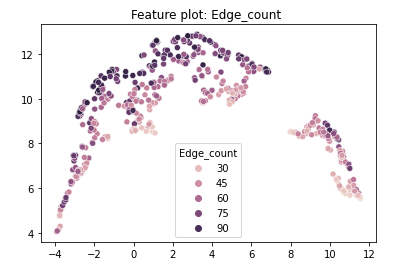

However structural composition often isn't enough to predict proteins function. Also, if two proteins share the same structural similarity, it does not have to be the case, that they share the function as, well. Only one amino acid (AA) mutation can alter the function of a protein. Therefore: **structural similarity does not always imply functional similarity**

Therefore, our focus in this part is to include more chemical feature into our new kernel. Features like: polarity, 3d length,  hydrophobicity, AA length, etc..



In [1]:
# load packages
from kernels import VertexHistogramLinearKernel, VertexHistogramKernelModified
import os
import sys
import time
import matplotlib.pyplot as plt
from grakel.datasets import fetch_dataset
from tudataset.tud_benchmark.auxiliarymethods import kernel_evaluation
import numpy as np
os.chdir("./tudataset/tud_benchmark")
from auxiliarymethods import auxiliary_methods as aux
os.chdir("../..")

In [2]:
# Loads the ENZYMES dataset
ENZYMES_attr = fetch_dataset("ENZYMES", prefer_attr_nodes=True, verbose=False) #loads all node attributes
ENZYMES_node_labels = fetch_dataset("ENZYMES", with_classes=True, verbose=False) #loads node labels

G, classes = ENZYMES_attr.data, ENZYMES_attr.target

In [3]:
gram_wl5 = "./precomputed_kernels/without_labels/ENZYMES_gram_matrix_wl5.csv"
gram_matrix = np.loadtxt(gram_wl5, delimiter=";")
gram_matrix_wl5 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

gram_graphlet = "./precomputed_kernels/without_labels/ENZYMES_gram_matrix_graphlet.csv"
gram_matrix = np.loadtxt(gram_wl5, delimiter=";")
gram_matrix_graphlet = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

In [4]:
# this function just changes the format of graph object so that it can be applied in the kernel object
def generate_attribute_data(attribute_index, G):
    ENZYMES_attr_subset= []
    SSE_count = 1
    for i in range(0, len(G)):
        enzyme = [G[i][0]]

        attr = {}
        for ss in range(0, len(G[i][1])):
            attr[SSE_count] = G[i][1][SSE_count][attribute_index]
            SSE_count += 1

        enzyme.append(attr)

        enzyme.append({})

        ENZYMES_attr_subset.append(enzyme)
    return(ENZYMES_attr_subset)

## 2.1 Kernel v1

Here we decided to apply vertex histogram kernel on a feature matrix which is just a linear combination of all 
node attributes and their corresponding weights. The weights were taken from ENZYMES publication paper.

In [9]:
# this is a function which calculate the feature matrix which is a linear combination of all 
# node attributes and their weights. The weights were taken from ENZYMES publication paper 
def generate_hyperkernel_feature_matrix(weights ,attr_index_list, G):
    ENZYMES_hyperkernel_features= []
    SSE_count = 1
    for i in range(0, len(G)):
        enzyme = [G[i][0]]

        attr = {}
        # iterate over ss elements
        for ss in range(0, len(G[i][1])):
            # calculate hyperkernel value
            attr[SSE_count] = 0
            for index, attribute_index in enumerate(attr_index_list):
                weight = weights[index]
                attr[SSE_count] += (weight * G[i][1][SSE_count][attribute_index])
            SSE_count += 1

        enzyme.append(attr)

        enzyme.append({})

        ENZYMES_hyperkernel_features.append(enzyme)
    return(ENZYMES_hyperkernel_features)

weights = [1,1, 1 ,1 , 0.12, 0.12, 0.12, 0.4, 0.13, 0.14, 0.13]
attr_index_list= [0, 7, 8, 9, 10, 11, 12 ,13, 15, 16, 17]

hyper_attr = generate_hyperkernel_feature_matrix(weights, attr_index_list, G )
G_subseted, classes = hyper_attr, ENZYMES_attr.target
# initialize kernel
hyper_kernel = VertexHistogramLinearKernel(normalize=True)
hyper_kernel_publication = hyper_kernel.fit_transform(G_subseted)

## 2.1 Generating other kernels
Here we use two linear kernels: **Vertex Histogram kernel and a modified vertex histogram kernel.**

The vertex histogram kernel is a simple linear kernel, that calculates label histograms for each graph, that is: counts the number of occurrences for each label value and as a kernel between two graphs calculate the sum of products between frequencies of common occurrences.

In our case we used vertex histogram not only on vertex labels but also node attributes. So the node attributes were treated as categorical variables, although they are discrete.

In the modified vertex kernel the approach was to take the node attribute and divide it into 50 categories based on the percentiles derived from global node attribute distribution. In some cases we can see that this approach works better than in classical vertex histogram kernel.


In the code we calculate and choose the best kernel (vertex histogram or modified one) for each node attribute. We also add a weight to each kernel, where weight corresponds to the accuraccy that we got from  SVM evaluation.

Those 18 kernels represent the chemical features, and for the structural features we took the WL-5 kernel.


All of those gram matrices were put into all_grams list variable


In [5]:
# generate kernel for each attribute
all_grams = []

kernels_accuraccies = {"VertexHistogram":[] , "VertexHistogramModified": []}
for attr_index in range(0, 18): # 18 node attributes
    ENZYMES_attr_subset = generate_attribute_data(attr_index, G)
    G_subseted, classes = ENZYMES_attr_subset, ENZYMES_attr.target
    
    # vertexhistogram vs categorizedhistogram
    # initialize kernel
    vertex_kernel = VertexHistogramLinearKernel(normalize=True)
    vertex_mod_kernel = VertexHistogramKernelModified(normalize=True)
    
    kernels = {"VertexHistogram": vertex_kernel,"VertexHistogramModified": vertex_mod_kernel}

    best_accurraccy = 0
    best_kernel = None
    for key, kernel in kernels.items():
        label_kernel_gram = kernel.fit_transform(G_subseted) # subsetting for faster testing
        
        print("Starting kernel svm evaluation...") 
        num_reps = 10
        accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation([label_kernel_gram] , classes, num_repetitions=num_reps, all_std=True)

        print ("accuracy:", accuracy)
        print ("standard deviations of all 10-CV runs:", std_10)
        print ("standard deviations of all 100 runs:", std_100)
        
        kernels_accuraccies[key].append(accuracy)
        
        if accuracy > best_accurraccy:
            best_accurraccy = accuracy
            best_kernel = label_kernel_gram
    
    all_grams.append((label_kernel_gram * best_accurraccy, best_accurraccy))

accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation([gram_matrix_wl5] , classes, num_repetitions=num_reps, all_std=True)
all_grams.append((gram_matrix_wl5 * accuracy, accuracy))



Starting kernel svm evaluation...
accuracy: 40.08333333333333
standard deviations of all 10-CV runs: 0.9523363084774441
standard deviations of all 100 runs: 6.49946579001348
Starting kernel svm evaluation...
accuracy: 34.0
standard deviations of all 10-CV runs: 0.9339283817414603
standard deviations of all 100 runs: 5.201495511442412
Starting kernel svm evaluation...
accuracy: 16.3
standard deviations of all 10-CV runs: 1.1566234381931646
standard deviations of all 100 runs: 3.96918687446742
Starting kernel svm evaluation...
accuracy: 38.23333333333333
standard deviations of all 10-CV runs: 1.3211947455070954
standard deviations of all 100 runs: 5.962009355540762
Starting kernel svm evaluation...
accuracy: 64.86666666666667
standard deviations of all 10-CV runs: 0.8225975119502072
standard deviations of all 100 runs: 5.546169849544818
Starting kernel svm evaluation...
accuracy: 44.43333333333333
standard deviations of all 10-CV runs: 1.7483325389257813
standard deviations of all 100 ru

In [6]:
def get_best_gram(gram_list):
    accuraccy_list = [x[1] for x in gram_list]
    best_gram_index = accuraccy_list.index(max(accuraccy_list))
    return(best_gram_index)

def get_best_gram_sorted(gram_list):
    accuraccy_list = [x[1] for x in gram_list]
    best_gram_index = sorted(range(len(accuraccy_list)),reverse = True,key = lambda k: accuraccy_list[k])
    return(best_gram_index)

In [7]:
def get_score(gram, labels):
    num_reps = 10
    accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation([label_kernel_gram] ,  labels, num_repetitions=num_reps, all_std=True)
    return accuracy
    

## 2.1 Cross Validation

After calculating all the kernels we want to find the best possible combination of the kernels for our hyperkernel. Here we apply the greedy approach in order to find the most optimal combination, while also reducing time complexity. The final product is a **hyperkernel_v2**

In [8]:
# let weight(k) for each kernel be their accuraccy 
#find best combination of kernels byjust using greedy approach
copy_gram = [i for i in all_grams]
best_gram_index = get_best_gram(all_grams)
best_gram = all_grams[best_gram_index][0]
del all_grams[best_gram_index]

# find second best combination with this gram
hyperkernel = best_gram
    
best_score = get_score(hyperkernel, classes )

for _ in range(0, len(all_grams)):
    sorted_index = get_best_gram_sorted(all_grams)
    best_candidate = None
    for candidate_index in sorted_index:
        gram = all_grams[candidate_index][0]

        gram_combination = hyperkernel * gram #(best_gram + gram)/2
        score = get_score(gram_combination, classes)

        if score > best_score:
            best_score = score
            best_candidate = candidate_index

    if best_candidate == None:
        break
    hyperkernel = (hyperkernel + (all_grams[best_candidate][0])/2)        

    del all_grams[best_candidate]
    
# normalize
diag = np.einsum('ij,ij->i', hyperkernel, hyperkernel)
hyperkernel =  hyperkernel / np.sqrt(np.outer(diag, diag))

## 3. Visualization and evaluation of the generated kernels
Here we evaluate 4 kernels: Graphlet kernel, WL-5 kernel, Hyperkernel_v1, Hyperkernel_v2
We evaluate the svm prediction for each EC class and all EC classes simultaneously.

In [ ]:
# calculate accuraccies for each EC class
compare_gram_list = {"Graphlet": gram_matrix_graphlet,"WL5":gram_matrix_wl5,  "ENZYME hyperkernel": hyper_kernel_publication, "Hyperkernel":hyperkernel}
kernels_accuraccies = {"Graphlet":[],"WL5": [], "ENZYME hyperkernel": [], "Hyperkernel": []}

for EC_class in range(1, 8):
    classes_EC = np.array([1 if i == EC_class else 0 for i in classes ])
    if(EC_class == 7):
        classes_EC = classes
    for key,gram in compare_gram_list.items():
        num_reps = 10
        accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation([gram] , classes_EC, num_repetitions=num_reps, all_std=True)
        kernels_accuraccies[key].append(accuracy)


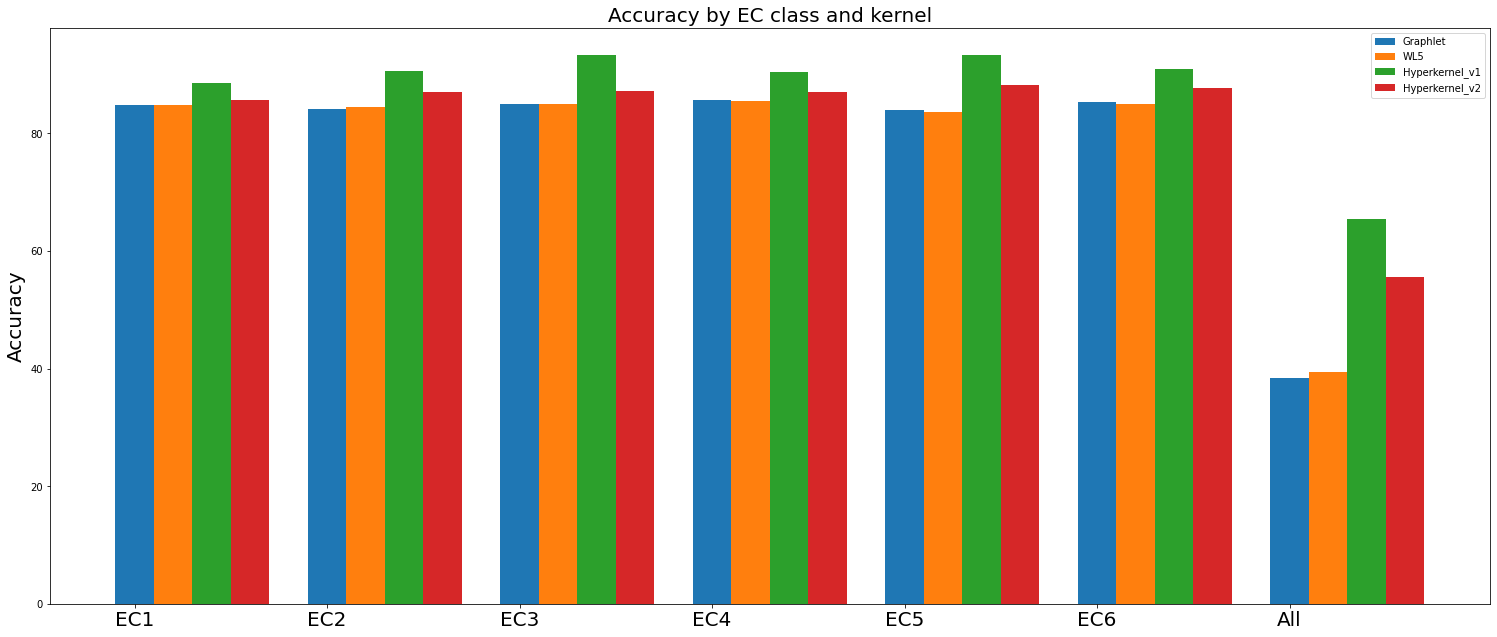

In [31]:
data = [values for values in kernels_accuraccies.values()]
labels = ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'All']

x = np.arange(len(labels)) 
width = 0.2
r1 = np.arange(len(labels))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
fig = plt.figure(figsize=(20,8))
ax = fig.add_axes([0,0,1,1])

rects1 = ax.bar(r1, data[0], width, label='Graphlet')
rects2 = ax.bar(r2, data[1], width, label='WL5')
rects3 = ax.bar(r3, data[2], width, label='Hyperkernel_v1')
rects4 = ax.bar(r4, data[3], width, label='Hyperkernel_v2')

ax.set_ylabel('Accuracy', fontsize= 20)
ax.set_title('Accuracy by EC class and kernel', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 20)
ax.legend()

plt.show()

In [32]:
np.savetxt("./precomputed_kernels/without_labels/ENZYMES_gram_matrix_hyperkernel_v2.csv",hyperkernel, delimiter=";")

v1: NMI-score: 0.4036
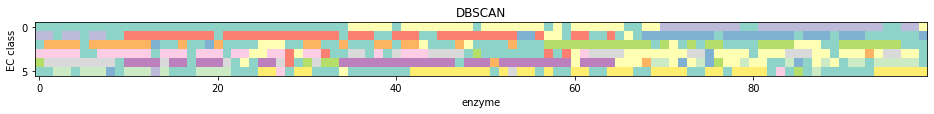

v2: NMI-score: 0.3433 
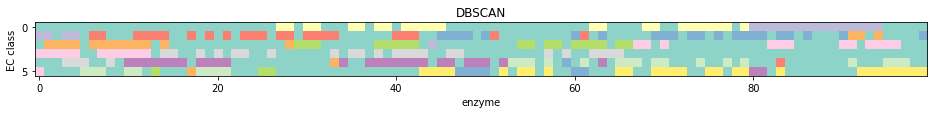

clustering works better than expected, but there is no real clues visible which could be used to improve the graph kernel. A possible approach would be to classify smaller substructures, and then add them up hierarchically. Since both biology and our clustering results tells us about these substructures, this should be an obvious next step when attempting to improve this kernel.


We successfully defined a enzymes graph kernel that measures similarity between enzymes graphs. We can definetely see that **by including chemical features into our kernel significantly improves the svm prediction compared to WL or graphlet kernels.**